In [ ]:
%matplotlib inline
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

Para importar las imagenes es necesario realizar una segmentacion por las caracteristicas que deseamos entrenar. En mi caso mi codigo se encarga de identificar si una imagen es hombre o mujer, de este modo, se segmentan dos carpetas unas para los hombres y otra para las mujeres. El siguiente codigo realiza una lectura de cada una de las carpetas y los archivos que hay en ellas:

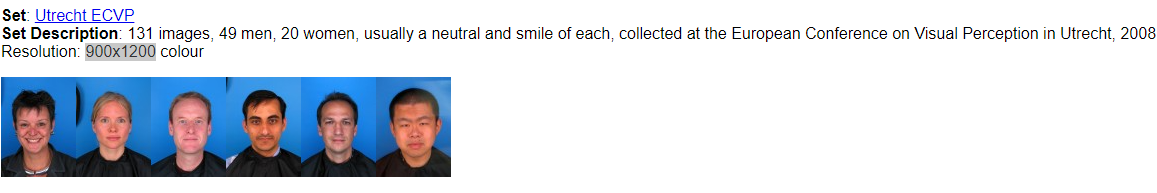

In [ ]:
IMAGE_DIR = '/content/drive/MyDrive/Faces'
DEFAULT_SIZE = [900,1200] 

def read_images(image_path=IMAGE_DIR, default_size=DEFAULT_SIZE):
    images = []
    images_names = []
    image_dirs = [image for image in os.listdir(image_path) if not image.startswith('.')]
    for image_dir in image_dirs:
        dir_path = os.path.join(image_path, image_dir)
        image_names = [image for image in os.listdir(dir_path) if not image.startswith('.')]
        for image_name in image_names:
            image = Image.open (os.path.join(dir_path, image_name))
            image = image.convert ("L")
            # resize to given size (if given )
            if (default_size is not None ):
                image = image.resize (default_size , Image.ANTIALIAS )
            images.append(np.asarray (image , dtype =np. uint8 ))
            images_names.append(image_dir)
    return [images,images_names]

In [ ]:
[X,y]=read_images() #"X" es la matriz imágen y "y" es la descripción o atributo

Representamos cada una de las imagenes como un vector, por lo tanto hay que realizar un proceso de redimension y lo que antes era (n,m) ahora sera de dimension (nxm,1)

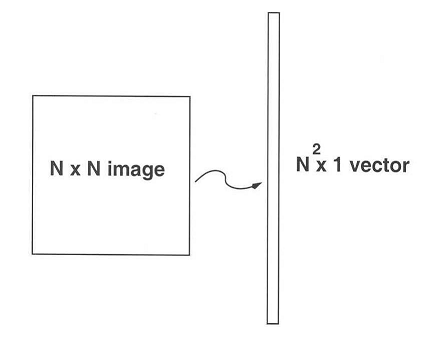


In [ ]:
def redim_matriz (X):
    if len (X) == 0:
        return np. array ([])
    mat = np. empty ((0 , X [0].size ), dtype =X [0]. dtype )
    for row in X:
        mat = np.vstack(( mat , np.asarray( row ).reshape(1 , -1))) # 1 x r*c 
    return mat

Aprovechamos para utilizar la funcion definida anteriormente y generamos un vector medio. Es decir, las medias de cada variable y la matriz de varianza-covarianza consta de las varianzas de las variables a lo largo de la diagonal principal y las covarianzas entre cada par de variables en las otras posiciones de la matriz

$\mu=\frac{1}{\mathrm{n}} \sum_{i=1}^{\mathrm{n}} x_{i}$

La cara media es el promedio de todas las caras indiscriminadamente si es mujer u hombre

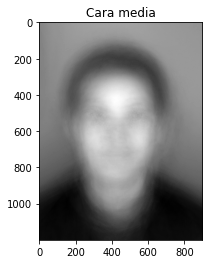

In [ ]:
cara_media = np.reshape(redim_matriz(X).mean( axis =0),X[0].shape) #Calculamos el vector medio o cara media
plt.imshow(cara_media, cmap=plt.cm.gray)
plt.title("Cara media")
plt.show()

**Análisis exploratorio de datos:**
Como el análisis que realizaremos es de imágenes, las características a representar son los cuadros de las imágenes en común por ello tenemos 1200*900 columnas de clasificación, mientras que tenemos 128 columnas, que son el número de imágenes de entrenamiento que tenemos o datos para cara características a representar. 

Los valores en la tabla representan la escala de color, en la matriz imágen

In [ ]:
vec=redim_matriz (X)
vec.shape

(129, 1080000)

In [ ]:
dataframe=pd.DataFrame(vec)
dataframe[vec.shape[1]]=y

x= dataframe[1080000].unique()
dataframe[1080001]=dataframe[1080000]
c=0
for i in x:
  c=c+1
  dataframe[1080000][dataframe[1080000]==i]=c

dataframe.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1079962,1079963,1079964,1079965,1079966,1079967,1079968,1079969,1079970,1079971,1079972,1079973,1079974,1079975,1079976,1079977,1079978,1079979,1079980,1079981,1079982,1079983,1079984,1079985,1079986,1079987,1079988,1079989,1079990,1079991,1079992,1079993,1079994,1079995,1079996,1079997,1079998,1079999,1080000,1080001
0,96,94,92,93,96,99,101,101,103,103,104,106,106,107,107,107,107,107,106,107,108,110,111,112,111,112,112,113,113,112,111,110,111,113,113,111,113,116,113,106,...,31,32,30,30,32,34,32,29,30,33,31,31,32,33,33,32,33,36,32,32,33,34,36,36,35,34,32,35,37,37,33,31,31,32,31,31,30,30,1,WOMEN
1,42,24,18,16,16,18,13,13,12,15,14,11,12,16,17,15,14,13,13,14,14,15,15,14,14,14,14,15,17,17,15,13,14,17,18,18,17,16,12,9,...,23,23,24,24,24,25,25,24,22,21,23,23,22,23,23,23,22,21,21,22,21,22,24,25,22,16,20,22,24,23,22,21,20,21,20,22,25,26,1,WOMEN
2,17,17,16,16,15,15,16,17,18,18,18,19,19,19,18,17,18,18,17,18,19,21,23,25,21,17,14,15,17,21,45,75,80,79,76,77,81,79,77,81,...,21,21,19,20,22,22,21,20,20,21,19,19,19,19,20,21,22,22,21,21,21,21,20,21,23,24,24,22,24,27,28,24,21,19,19,19,18,18,1,WOMEN
3,15,15,16,16,16,16,15,15,14,15,16,18,19,18,16,14,15,15,16,17,18,19,20,20,19,18,15,11,11,22,38,51,61,72,77,78,82,85,83,82,...,26,26,25,24,23,23,23,23,23,23,24,22,20,19,18,19,18,18,18,18,20,21,23,23,22,21,19,23,25,21,19,21,20,18,17,16,14,14,1,WOMEN
4,88,89,90,91,92,93,94,94,96,96,98,100,101,101,100,99,102,101,102,104,104,103,103,106,108,108,107,106,104,104,104,104,105,107,109,109,108,107,107,108,...,24,23,28,28,28,27,26,27,28,30,27,26,24,24,25,26,25,25,26,26,26,27,28,28,27,26,30,30,29,29,30,30,30,29,27,29,28,26,1,WOMEN


Donde 1 es la categoría mujer y 2 la categoría hombre

Como es de esperarse, se encuentra una mayor variabilidad en las casillas del centro, es decir donde hay imágen, mientras que en el fondo e incluso partes de la cara encontramos una mayor correlación

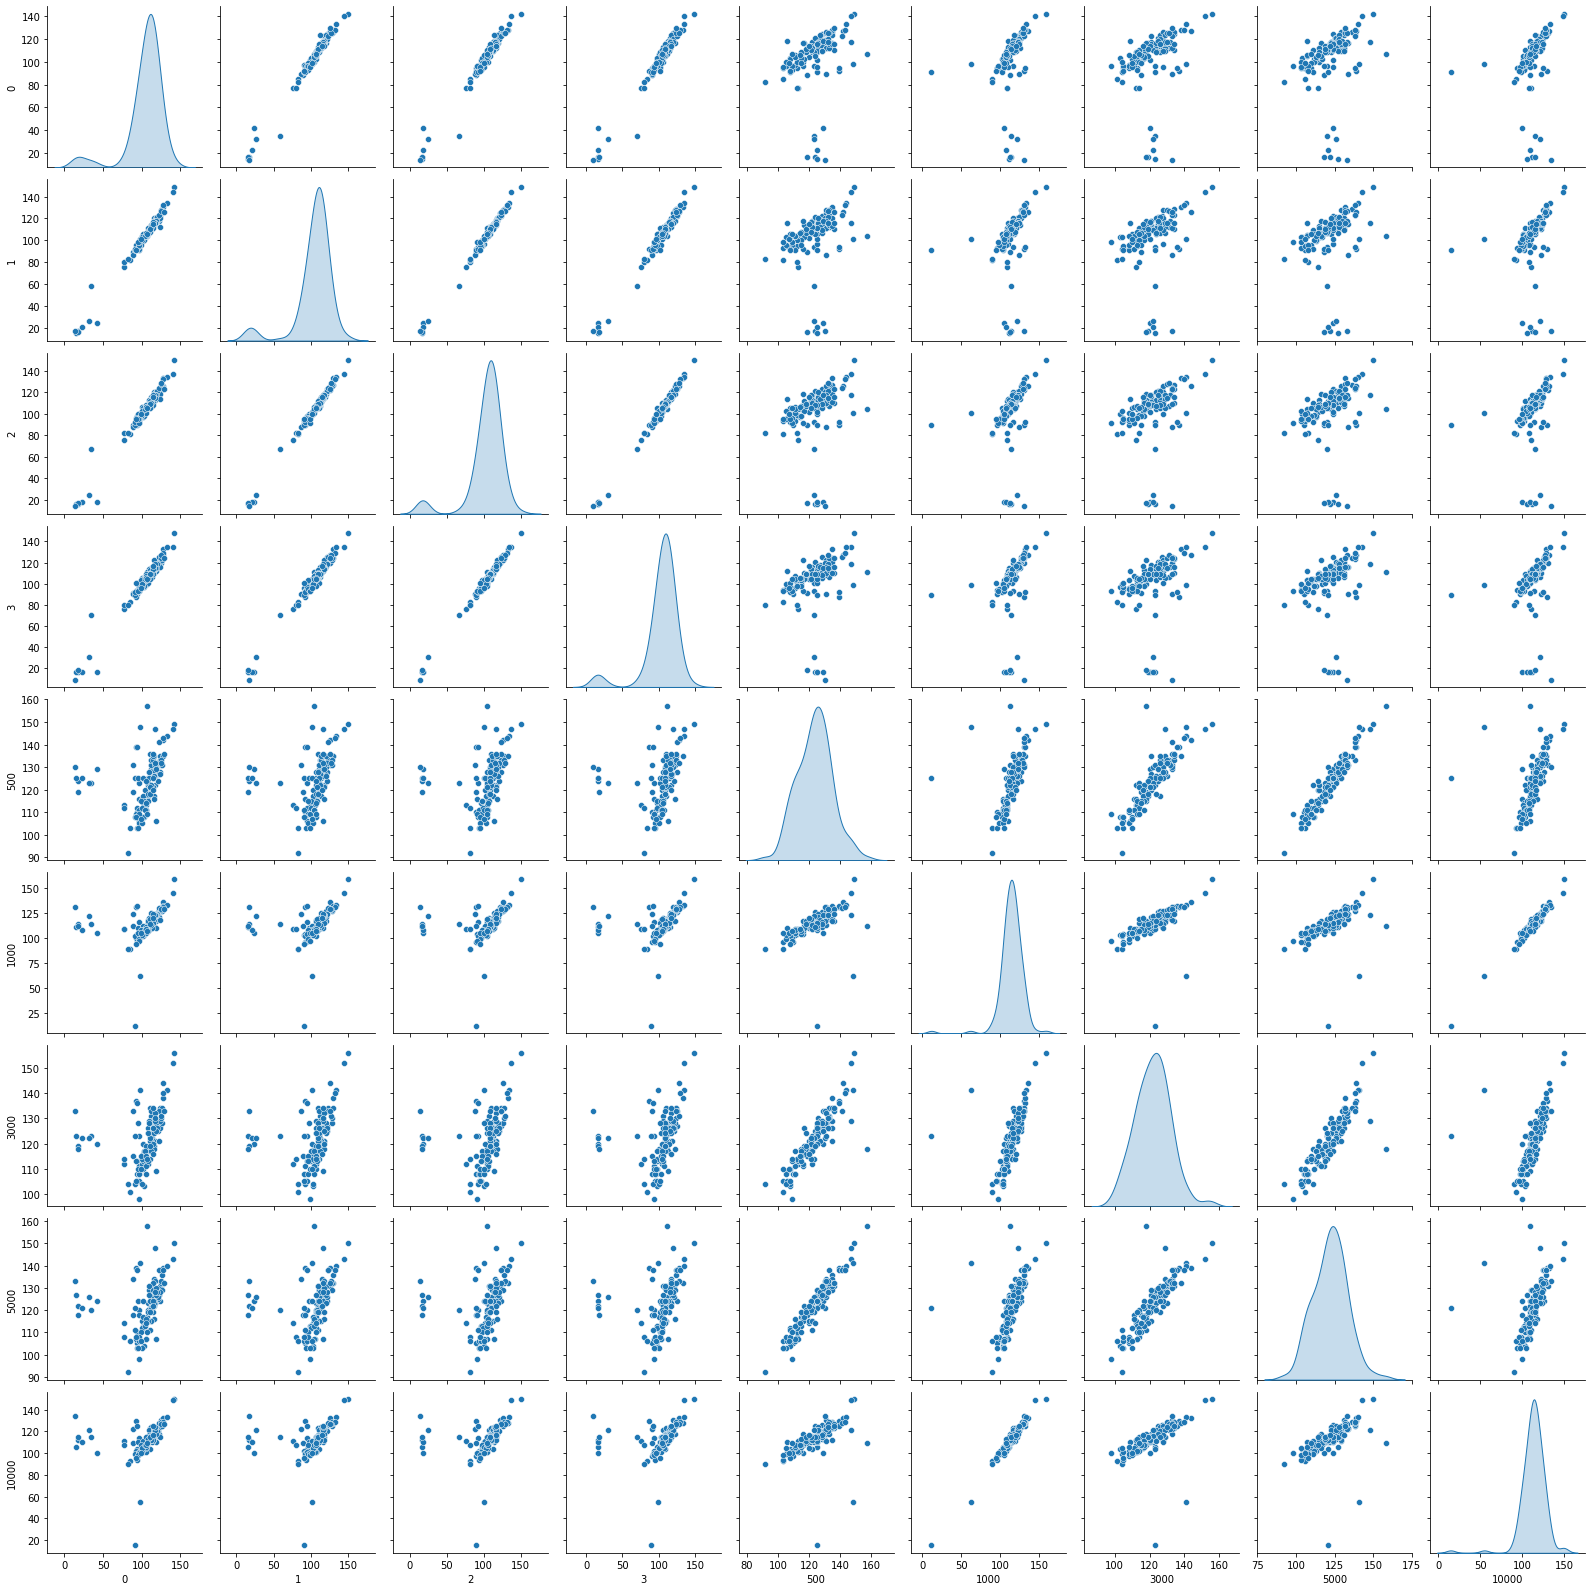

In [ ]:
sns.pairplot(dataframe[[0,1,2,3,500,1000,3000,5000,10000]],diag_kind="kde")

In [ ]:
dataframe2=dataframe[[0,1,2,3,500,1000,3000,5000,10000,1080000]]
dataframe2.head()

,0,1,2,3,500,1000,3000,5000,10000,1080000
0,96,94,92,93,123,116,123,120,114,1
1,42,24,18,16,129,105,120,124,100,1
2,17,17,16,16,124,114,119,122,112,1
3,15,15,16,16,125,111,123,127,106,1
4,88,89,90,91,119,112,115,118,109,1


[]

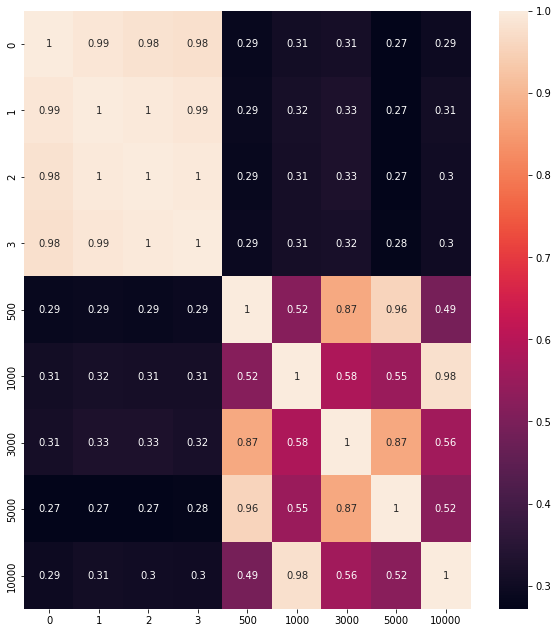

In [ ]:
plt.figure(figsize=(10,11))
sns.heatmap(dataframe2.corr(), annot=True)
plt.plot()

Vaos a encontrar una correlación casi perfecta en los sitios que la imágen tiene fondo, los lugares de la piel y cabello. Las casillas que nos brindarán una mayor variabilidad están dadas por los ojos, la nariz, curvatura de la cara, boca, etc.

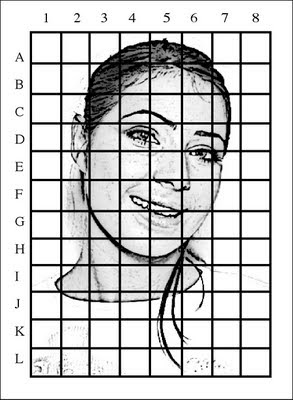

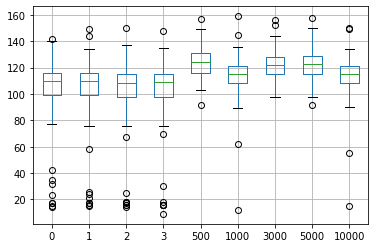

In [ ]:
dataframe2.boxplot([0,1,2,3,500,1000,3000,5000,10000])

### **2. Clasificación Bayesiana**
Para este análisis debemos suponer independencia de las variables de predicción, por ello se le llama ingénuo. En términos simples, un clasificador de Naive Bayes asume que la presencia o ausencia de una característica particular no está relacionada con la presencia o ausencia de cualquier otra característica, dada la clase variable.

2.1. Particionamos muestras de entrenamiento con la función sklearn.model, donde se particiona la muestra en 2: Hombres y mujeres
sklearn.model_selection.train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(vec, y, test_size=0.4, random_state=60)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test) #P(x|y=c)

In [ ]:
X_train.shape #Entrenamos el 40% de los datos

(77, 1080000)

Encontramos la matriz de confusión
Verifiquemos como es el modelo utilizando las métricas de los problemas de clasificación, para ello vamos a comenzar obteniendo la matriz de confusión. Para esto importamos del modulo skk¡learn.metrics, confusion_matrix, y aplicamos esta instrucción junto a los datos de prueba y los obtenidos en la predicción realizada previamente.
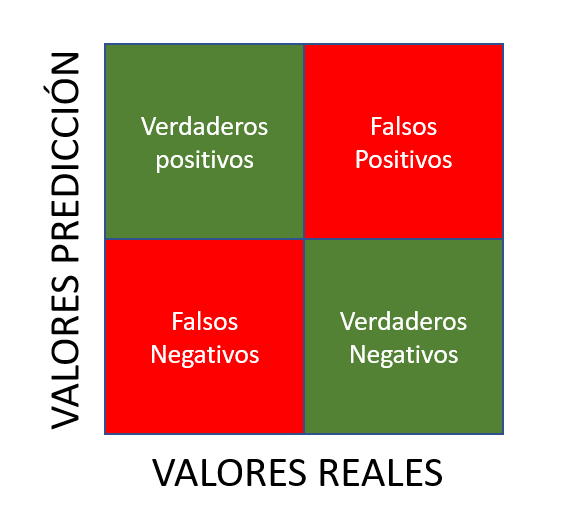


In [ ]:
from sklearn.metrics import confusion_matrix
matriz = confusion_matrix(y_test, y_pred)
print('Matriz de Confusión:')
print(matriz)

Matriz de Confusión:
[[31  4]
 [ 3 14]]


Esto nos indica que, tenemos 45 datos entrenados correctamente, pero, obtenemos un error de 7.
Estos valores pueden variar depediendo del tamaño de la muestra. Se puede realizar un proceso de optimización que minimice el error a través de los parámetros de entada para nuestra función GaussianNB.

Adicional a esto, evaluando el modelo indica un 86.56% de ajuste con todas las componentes de X

2.2. Resultado del modelo de entrenamiento

In [ ]:
np.mean(y_pred == y_test)

0.8653846153846154

2.3. Componentes del análisis: matriz de covarianza

$\mathrm{S}=\frac{1}{\mathrm{n}} \sum_{i=1}^{\mathrm{n}}\left(x_{i}-\mu\right)\left(x_{i}-\mu\right)^{\mathrm{T}}$
$\mathrm{S} v_{\mathrm{i}}=\lambda_{i} v_{i}, \mathrm{i}=1,2, \ldots, \mathrm{n}$

Calculamos las componentes de covarianza para sacar los primeros componentes principales para calcular el impacto de usar solamentelas primeras 3 componentes

In [ ]:
len(X_train)

77

In [ ]:
[n,d] = X_train.shape
mu = X_train.T.mean(axis =0)
C=(X_train.T-mu)

In [ ]:
S=np.dot(C.T,C)

In [ ]:
S

array([[2.24857569e+09, 1.30825941e+09, 1.31964730e+09, ...,
        1.76197274e+09, 1.56530786e+09, 1.59713294e+09],
       [1.30825941e+09, 2.48049313e+09, 1.59991932e+09, ...,
        1.60820454e+09, 1.73843019e+09, 2.01301234e+09],
       [1.31964730e+09, 1.59991932e+09, 2.45346150e+09, ...,
        1.41767527e+09, 1.67526335e+09, 1.74865223e+09],
       ...,
       [1.76197274e+09, 1.60820454e+09, 1.41767527e+09, ...,
        2.32952735e+09, 1.81379120e+09, 1.86274296e+09],
       [1.56530786e+09, 1.73843019e+09, 1.67526335e+09, ...,
        1.81379120e+09, 2.80209152e+09, 2.26213768e+09],
       [1.59713294e+09, 2.01301234e+09, 1.74865223e+09, ...,
        1.86274296e+09, 2.26213768e+09, 2.73044986e+09]])

Las k componentes principales del vector observado x vienen dadas por:

$y=W^{T}(x-\mu)$

Donde w es la matriz de vectores propios
Este vector observado y será nuestro nuevo vector propio

In [ ]:
[w,v] = np.linalg.eigh(S)

2.4. Proyectar el conjunto de entrenamiento sobre las 3 primeras componentes principales. o vectores propios hallados. No vamos a proyectar las imágenes sobre todas las componentes sino sobre 3. Para eso usamos un conjunto de imágenes para evaluar el resultado del modeo

1. Ordenamos la matriz W de vectores propios para realizar las respectivas proyecciones

Donde U es nuestro arreglo de vectores propios y A es 

$(x-\mu)$

In [ ]:
U = np.zeros(X_train.T.shape) #Matriz de ceros de tamaño N^2 * m_train
order = np.argsort(w) # Orden de las posiciones de los euginvalues
for i in range(n):
    u_vector = C @ v[i].reshape(-1,1)
    u_vector = u_vector/np.linalg.norm(u_vector)
    U[:, n-1-order[i]] = u_vector.reshape(-1)

Para hacer el ajuste del modelo, es necesario realizar la proyección de cada una de las k componentes sobre la dispersión de los datos respecto a la media:


$y=W^{T}(x-\mu)$

La combinación lineal entre los vectores propios nos dará el ajuste de la cara n

El resultado del siguiente ciclo es una matriz de arreglos de X estimados a través de la combinación lineal de los primeros 3 componentes y este será nuestro parámetro de entrada en nuestra función gaussiana.

In [ ]:
U.shape

(1080000, 77)

In [ ]:
# Obteniendo solo las 3 primeras componentes de análisis
shape= X_train.T.shape
X_ = np.zeros(shape)
for face_n in range(n):
  for k_value in range(1, 4):
    face = np.zeros(shape) #Matriz de ceros de tamaño N^2 * m
    for i in range(k_value):
      w_ = U[:,i].T @ C[:,face_n]
      face[:,i] = w_*U[:,i]
    X_[:,face_n] = np.sum(face, axis=1)
        # print(f"Face {face_n+1} ed = {np.linalg.norm(A[:, face_n] - face)}")
gnb = GaussianNB()
    # Ajustando el modelo a las 3 principales componentes
y_pred = gnb.fit(X_.T, y_train).predict(X_test)
print(f"PCA = {3} = {np.mean(y_pred == y_test)} %")

PCA = 3 = 0.6730769230769231 %


Inicialmente el modelo obtuvo un 86.56% por ciento de precisión mientras que si utilizamos el conjunto de entrenamiento proyectado solo a 3 componentes de análisis principales se obtiene del modelo solo un 67.31% por ciento de eficacia, siendo muy acercado al valor inicial con los valores de entrenamiento X. Teniendo en cuenta que este porcentaje de eficacia cambia cuando modificamos los parámetros de entrenamiento X_train, X_test, y_train, y_test = train_test_split(vec, y, test_size=0.4, random_state=60)

2.5. Entrenar el clasificador Bayesiano empleando el conjunto de entrenamiento proyectado y evaluarlo.

Usamos el algoritmo para deteccion:

En el proceso de reconocimiento, se forma una cara propia para la imagen de la cara dada, y se calculan las distancias euclidianas entre esta cara propia y las caras propias almacenadas previamente. La cara propia con la distancia euclidiana más pequeña es la que más se parece a la persona.

1. La reconstrucción a partir del algoritmo de predicción con la función predict

In [ ]:
y_pred = gnb.fit(X_.T, y_train).predict(X_test)

In [ ]:
image = Image.open("/content/drive/MyDrive/Prueba/f4021s.jpg")
image = image.convert ("L")
if (DEFAULT_SIZE is not None ):
    image = image.resize (DEFAULT_SIZE , Image.ANTIALIAS )
test_image = np. asarray (image , dtype =np. uint8 )

In [ ]:
X_img=test_image.flatten()
X_img=X_img.reshape(-1, 1)

1. Modelo con ajuste de parámetros, uso solamente las 3 principales componentes:
$p(y=c \mid \mathbf{x})=\frac{p(\mathbf{x} \mid y=c) p(y=c)}{p(\mathbf{x})} \propto p(\mathbf{x} \mid y=c) p(y=c)$

In [ ]:
pred=gnb.predict(X_img.T)
pred[0]

'MEN'

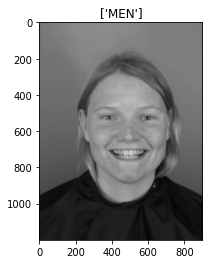

In [ ]:
plt.imshow(test_image, cmap=plt.cm.gray)
plt.title(pred)
plt.show()

1. Modelo con ajuste de parámetros:
$p(y=c \mid \mathbf{x})=\frac{p(\mathbf{x} \mid y=c) p(y=c)}{p(\mathbf{x})} \propto p(\mathbf{x} \mid y=c) p(y=c)$

In [ ]:
y_pred = gnb.fit(X_train, y_train).predict(X_test)

In [ ]:
pred=gnb.predict(X_img.T)
pred[0]

'WOMEN'

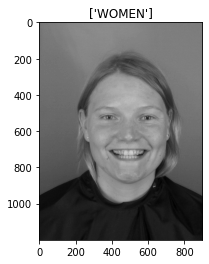

In [ ]:
plt.imshow(test_image, cmap=plt.cm.gray)
plt.title(pred)
plt.show()

### **Conclusiones**
Podemos observar que calculando solamente la proyección sobre las primeras 3 componentes nos dá un resultado aproximado del 67.31% de eficacia, lo cual no es muy alejado, esto se debe a que nuestras componenetes de resutado y son solo 2. Evaluandolo usando la función .fit ajustanto sus parametros y luego usando .predict obteniendo un mal ajuste.

el hecho de que la clasificación bayesiana requiera asumir que las características son independientes genera un menor ajuste, pero, utilizando PCA con una mayor cantidad de componentes puede dar un mejor ajuste en el modelo gracias a su enfoque de proyecciones sobre los valores muestra y las matrices de covarianza.

En el caso de PCA (el cual hace parte de algoritmos no supervisado), la variable respuesta Y no se tiene en cuenta ya que el objetivo no es predecir "Y" sino extraer información empleando los predictores, por ejemplo, para identificar subgrupos, por esto, podemos encontrar mejores ajustes con el uso de este algoritmo. 
